In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

sns.set_style('whitegrid')
%matplotlib inline

ModuleNotFoundError: No module named 'xgboost'

In [3]:
FN = "CAR DETAILS FROM CAR DEKHO.csv"

try:
    df = pd.read_csv(FN)
    print("Loaded dataset with shape:",df.shape)
    display(df.head())
except FileNotFoundError as e:
    print(f"couldn't find the {FN}")

Loaded dataset with shape: (4340, 8)


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [5]:
df.info

<bound method DataFrame.info of                                      name  year  selling_price  km_driven  \
0                           Maruti 800 AC  2007          60000      70000   
1                Maruti Wagon R LXI Minor  2007         135000      50000   
2                    Hyundai Verna 1.6 SX  2012         600000     100000   
3                  Datsun RediGO T Option  2017         250000      46000   
4                   Honda Amaze VX i-DTEC  2014         450000     141000   
...                                   ...   ...            ...        ...   
4335  Hyundai i20 Magna 1.4 CRDi (Diesel)  2014         409999      80000   
4336           Hyundai i20 Magna 1.4 CRDi  2014         409999      80000   
4337                  Maruti 800 AC BSIII  2009         110000      83000   
4338     Hyundai Creta 1.6 CRDi SX Option  2016         865000      90000   
4339                     Renault KWID RXT  2016         225000      40000   

        fuel seller_type transmission      

In [7]:
data = df.copy()

data.drop_duplicates(inplace=True)
print("After Dropping Duplicates:",data.shape)

print("\nMissing values per colunm:")
print(data.isnull().sum())

import datetime
current_year = datetime.datetime.now().year
if 'year' in data.columns:
    data['car_age'] = current_year - data['year']
    data.drop('year',axis=1,inplace=True)
    print("\nConverted 'year' -> 'car_age'.")

possible_price_cols = ['selling_price','price','sellingprice','sell_price']
price_col = None
for c in possible_price_cols:
    if c in data.columns:
        price_cols = c
        break
if price_col is None:
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    print("\nNone obvious price column found.Numeric Columns:",numeric_cols)
else:
    print(f"Using price column: {price_col}")
    data[price_col] = pd.to_numeric(data[price_col],errors='coerce')
    data = data.dropna(subset=[price_col])
    q_hi = data[price_col].quantile(0.995)
    data = data[data[price_col] <= q_hi]
    print(f"Filtered extreme prices above the 99.5th percentile ({q_hi:.2f}). New shape:", data.shape)

display(data.head())

After Dropping Duplicates: (3577, 8)

Missing values per colunm:
name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
dtype: int64

Converted 'year' -> 'car_age'.

None obvious price column found.Numeric Columns: ['selling_price', 'km_driven', 'car_age']


,name,selling_price,km_driven,fuel,seller_type,transmission,owner,car_age
0,Maruti 800 AC,60000,70000,Petrol,Individual,Manual,First Owner,18
1,Maruti Wagon R LXI Minor,135000,50000,Petrol,Individual,Manual,First Owner,18
2,Hyundai Verna 1.6 SX,600000,100000,Diesel,Individual,Manual,First Owner,13
3,Datsun RediGO T Option,250000,46000,Petrol,Individual,Manual,First Owner,8
4,Honda Amaze VX i-DTEC,450000,141000,Diesel,Individual,Manual,Second Owner,11


In [9]:
print("Columns:",data.columns.tolist())

cols_to_keep = []
for c in ['km_driven','car_age','fuel','seller_type','transmission','owner','selling_price','name','company']:
    if c in data.columns:
        cols_to_keep.append(c)
print("keeping columns:",cols_to_keep)
data = data[cols_to_keep].copy()

if 'selling_price' not in data.columns and price_col is not None:
    data.rename(columns={price_col: 'selling_price'}, inplace=True)

if 'name' in data.columns and 'company' not in data.columns:
    data['company'] = data['name'].apply(lambda x: str(x).split()[0] if pd.notnull(x) else 'unknown')

if 'km_driven' in data.columns:
    data['km_driven'] = data['km_driven'].apply(lambda x: str(x).replace(',', '') if pd.notnull(x) else x)
    data['km_driven'] = pd.to_numeric(data['km_driven'], errors='coerce').fillna(0).astype(int)
if 'owner' in data.columns:
    data['owner'] = data['owner'].astype(str).str.replace(' ','_')

cat_cols = data.select_dtypes(include=['object']).columns.tolist()
for c in cat_cols:
    data[c] = data[c].fillna("Unknown")
categorical_cols = [c for c in ['fuel','seller_type','transmission','owner','company'] if c in data.columns]
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

print("After encoding shape:",data.shape)
display(data.head())

Columns: ['name', 'selling_price', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'car_age']
keeping columns: ['km_driven', 'car_age', 'fuel', 'seller_type', 'transmission', 'owner', 'selling_price', 'name']
After encoding shape: (3577, 43)


,km_driven,car_age,selling_price,name,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,...,company_Mercedes-Benz,company_Mitsubishi,company_Nissan,company_OpelCorsa,company_Renault,company_Skoda,company_Tata,company_Toyota,company_Volkswagen,company_Volvo
0,70000,18,60000,Maruti 800 AC,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,50000,18,135000,Maruti Wagon R LXI Minor,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
2,100000,13,600000,Hyundai Verna 1.6 SX,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,46000,8,250000,Datsun RediGO T Option,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
4,141000,11,450000,Honda Amaze VX i-DTEC,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


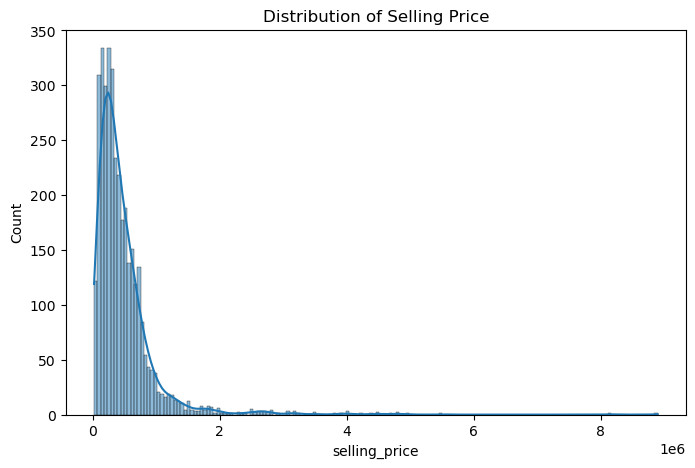

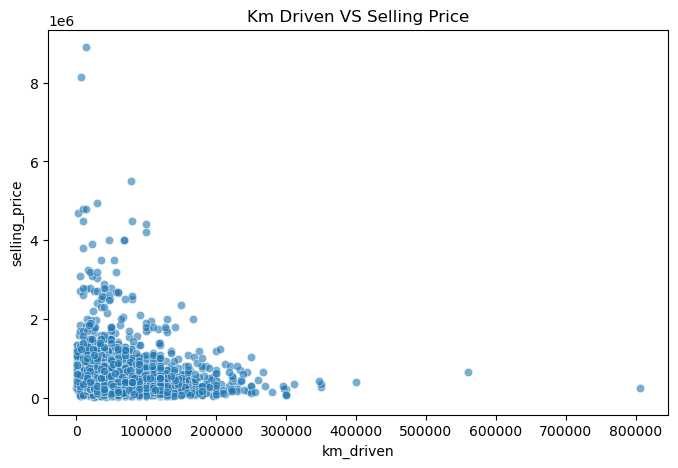

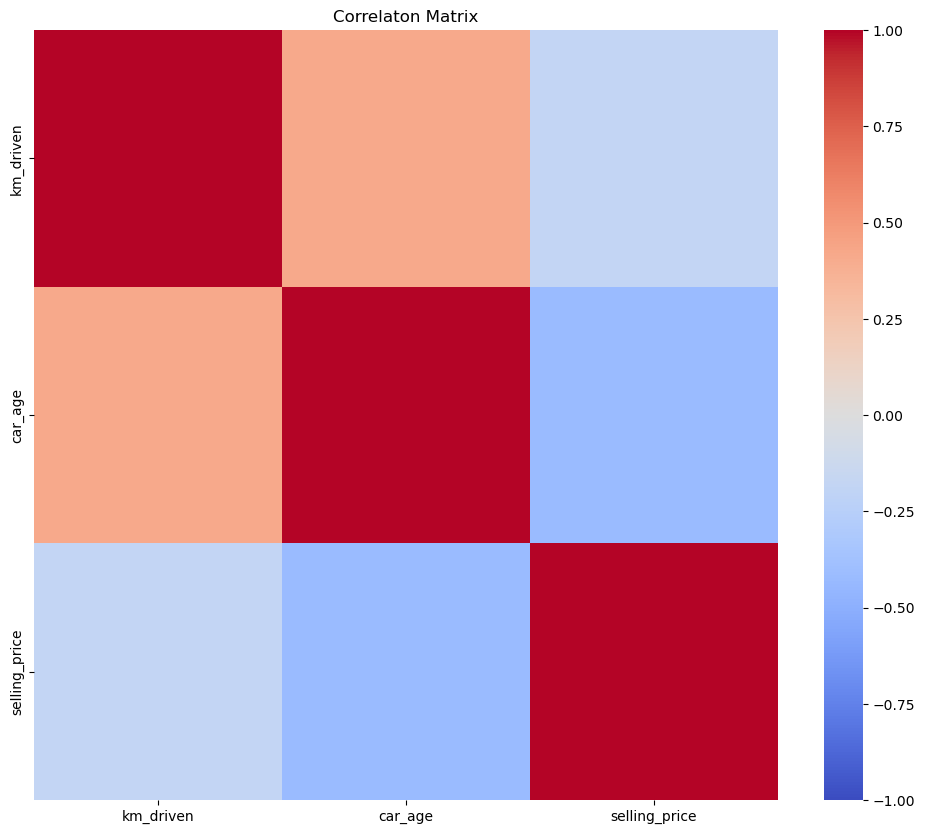

In [15]:
plt.figure(figsize=(8,5))
sns.histplot(data['selling_price'],kde=True)
plt.title("Distribution of Selling Price")
plt.show()

if 'km_driven' in data.columns:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x="km_driven",y="selling_price",data=data,alpha=0.6)
    plt.title('Km Driven VS Selling Price')
    plt.show()

num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
corr = data[num_cols].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr,cmap='coolwarm',center=0,vmax=1,vmin=-1)
plt.title('Correlaton Matrix')
plt.show()

In [17]:
X = data.drop('selling_price',axis=1)
y = data['selling_price']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print("Train shape:",X_train.shape,"Test shape:",X_test.shape)

Train shape: (2861, 42) Test shape: (716, 42)


In [33]:
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

models = {
    'Linear Regression' : LinearRegression(),
    'Random Forest' : RandomForestRegressor(n_estimators=100,random_state=42),
    'XGBoost' : XGBRegressor(n_estimators=100,random_state=42,verbosity=0)
}
results = {}
for name,model in  models.items():
    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test,preds)
    rmse = mean_squared_error(y_test,preds,squared=False)
    r2 = r2_score(y_test,preds)
    results[name] = {'MAE':mae,'RMSE':rmse,'R2':r2}
    print(f"{name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.3f}")

res_df = pd.DataFrame(results).T.sort_values('R2',ascending=False)
display(res_df)
    

Linear Regression -> MAE: 236606.53, RMSE: 517406.67, R2: 0.169
Random Forest -> MAE: 254270.09, RMSE: 542507.50, R2: 0.086
XGBoost -> MAE: 251348.47, RMSE: 542345.10, R2: 0.087


,MAE,RMSE,R2
Linear Regression,236606.533509,517406.671155,0.168948
XGBoost,251348.471914,542345.098037,0.086906
Random Forest,254270.089051,542507.504672,0.086359


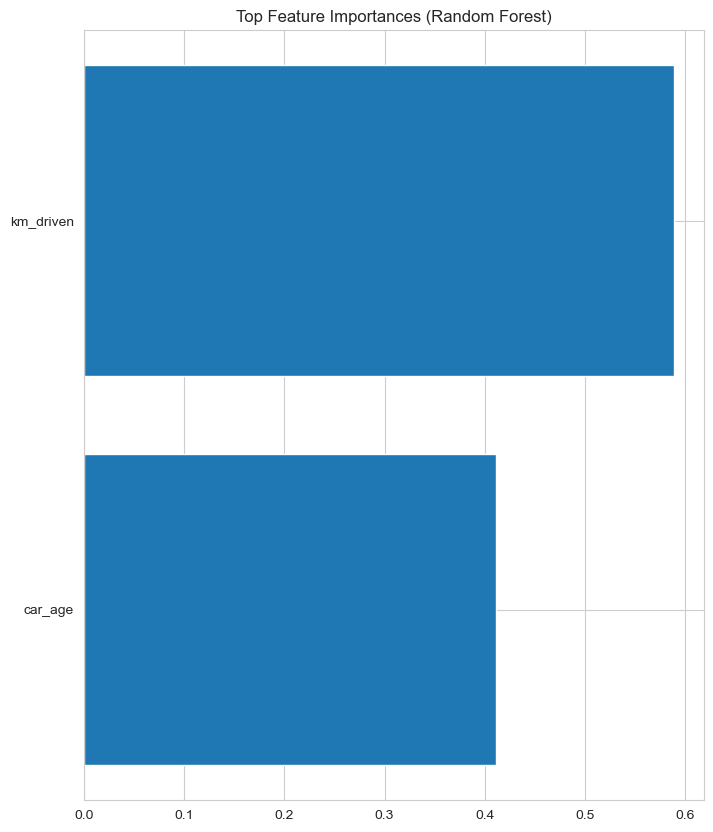

In [35]:
best = RandomForestRegressor(n_estimators=200, random_state=42)
best.fit(X_train, y_train)
importances = best.feature_importances_
indices = np.argsort(importances)[-20:]  # top 20 features
plt.figure(figsize=(8,10))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.title('Top Feature Importances (Random Forest)')
plt.show()


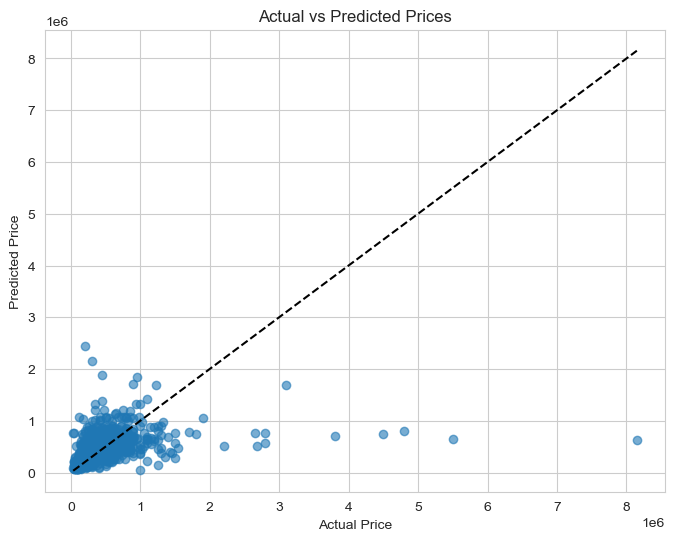

,actual,predicted
2103,650000,647883.888889
1376,425000,997135.416667
3308,1000000,351862.500000
3051,400000,495195.062917
2721,330000,310442.442500
3088,75000,121269.797439
543,850000,564617.877190
935,735000,331492.500000
1786,409999,351025.710678
2439,150000,387772.226130


In [37]:
preds = best.predict(X_test)
plt.figure(figsize=(8,6))
plt.scatter(y_test, preds, alpha=0.6)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
lims = [min(y_test.min(), preds.min()), max(y_test.max(), preds.max())]
plt.plot(lims, lims, '--', color='black')  # diagonal line
plt.show()

# Display sample comparisons
comp = pd.DataFrame({'actual': y_test, 'predicted': preds})
display(comp.sample(10))

In [39]:
joblib.dump(best, 'car_price_model.pkl')
print('Saved model to car_price_model.pkl')

Saved model to car_price_model.pkl
